In this notebook we go through some basic validation and analysis of data in ELAN files. The same can be adapted to other files and data sources – once we have it in a dictionary or data frame the things are similar. There is also a data format called "feather" that can be used to save data in a tabular structure that can be read to both Python and R data frames.

First we load some libraries. Pympi can be installed with `pip install pympi-ling`.

In [1]:
from pathlib import Path
import pympi
import re

This example removes a bunch of tiers from an ELAN file. We do not check if they have content or not, so this is not the most delicate appoach.

In [2]:
elan_path = "corpus/kpv_csys19570000-291_1a-Mezador.eaf"

tier_regex = r".?(UPA|CYR|LAT|IPA|word|morph|ft-deu|ft-nob|ft-swe|ft-ling|ft-fin|lemma|pos|lg\(word\)|note\(word\))@.?"

elan = pympi.Elan.Eaf(elan_path)

tiers = elan.get_tier_names()

for tier in list(tiers):
        
    if re.findall(tier_regex, tier):

        elan.remove_tier(tier)
        
elan.to_file(elan_path.replace("corpus", "corpus_clean"))

Parsing unknown version of ELAN spec... This could result in errors...


Here we create a list that has all ELAN files in our corpus.

In [3]:
elan_corpus = []

for file in Path("corpus").glob("*eaf"):
    
    elan_corpus.append(file)

In [4]:
elan_corpus

[PosixPath('corpus/kpv_uvyc19570000-290_3bz-Pop.eaf'),
 PosixPath('corpus/kpv_udo19570000-290_3a-Ust-Vacerga.eaf'),
 PosixPath('corpus/kpv_csys19570000-291_1a-Mezador.eaf'),
 PosixPath('corpus/kpv_vym19570000-290_3a-Soska.eaf'),
 PosixPath('corpus/kpv_csys19611213-1329_2az-Kunib.eaf'),
 PosixPath('corpus/kpv_izva19570000-290_3bz-Bakur.eaf')]

We loop through those files, and read every tier of type `orthT`. We collect this data into a dictionary, and pick all other information that we have in the filename and participant naming conventions. Here the filenames contain a language and a dialect tag, i.e. kpv_udo means Udora dialect of Komi. And the names are of type NTP-M-1986, meaning Niko Tapio Partanen, male, born in 1986.

In [5]:
elan_data = []

for file in elan_corpus:
    
    elan = pympi.Elan.Eaf(file)
    
    tiers = elan.get_tier_ids_for_linguistic_type("orthT")
    
    for tier in tiers:
        
        annotations = elan.get_annotation_data_for_tier(tier)
        
        for annotation in annotations:
            
            a = {}
            
            a['start_ms'] = annotation[0]
            a['end_ms'] = annotation[1]
            a['utterance'] = annotation[2]
            a['reference'] = annotation[3]
            a['participant'] = tier.split("@")[1]
            a['gender'] = a['participant'].split("-")[1]
            a['birthyear'] = a['participant'].split("-")[2]
            a['dialect'] = re.search(r"(?<=kpv_)(izva|csys|izva|udo|uvyc|vym)", str(file)).group(0)
            a['filename'] = str(file)
            
            elan_data.append(a)

Parsing unknown version of ELAN spec... This could result in errors...
Parsing unknown version of ELAN spec... This could result in errors...
Parsing unknown version of ELAN spec... This could result in errors...
Parsing unknown version of ELAN spec... This could result in errors...


In [6]:
elan_data[0]

{'start_ms': 1765,
 'end_ms': 8825,
 'utterance': 'Ме чужи Удора районын, Усть-Вачерга сиктын, коді сулалӧ Вашка ю дорын.',
 'reference': 'kpv_udo19570000-290_3a-01',
 'participant': 'XUV-F-1920',
 'gender': 'F',
 'birthyear': '1920',
 'dialect': 'udo',
 'filename': 'corpus/kpv_udo19570000-290_3a-Ust-Vacerga.eaf'}

This is how the annotations look like:

In [7]:
for annotation in elan_data:

    print(annotation['start_ms'], annotation['end_ms'], annotation['utterance'])

1765 8825 Ме чужи Удора районын, Усть-Вачерга сиктын, коді сулалӧ Вашка ю дорын.
17551 21030 Миян зэв, природаыс миян зэв мича.
21416 23873 Гӧгӧр сулалӧны яг.
24275 26053 Сиктсӧ ягӧн гӧгӧртӧма.
27708 31646 И юыс миян сэтшӧм визюв мый
32136 37646 ю вылас кӧ пыжӧн сынан сразу пыр ӧтнад кӧ сынан ӧтнад он вермы мыйкӧ керны, сразу нуыштас кытчӧ кӧ.
38270 40203 И если кӧ,
41586 44076 на пример ӧтчыд мӧдӧдчим
46886 51081 Йилемъяскӧд мӧдӧдчим пужӧн льӧм вотны.
51081 53745 Мунім, кыытім, кыытім, юӧдіс
53745 56833 и друг сэтшӧм виам воис
56833 60810 мый миянлысь пыжнымӧс бергӧдіс и ставным усим юас.
60810 64316 А оказывайтся абу вӧлӧма йир и
64316 68660 ми гортӧдз эта берег дорӧдзыс
68881 71573 йылан котырыс ӧдва и доберитчим.
72596 73573 Сэсся
75170 81305 миян колӧ мунны районнӧй чентрсяньыс Усть-Вачерга сиктӧдзыс квайтымын километр.
81305 82626 квайтымын верс.
82835 86938 И сэті туйыс зэв лёк, а ми велӧдчим
87321 91741 Кослан, Косланын, помалім семилеткасӧ и велӧдчим
91838 93505 Косланас, райо

Here we test which transcriptions have non-allowed characters (from the point of view of Komi).

In [8]:
for annotation in elan_data:
    
    if re.match(r"[^А-ЯЁӦІа-яёӧі,.!?…]", annotation['utterance']):

        print(annotation['filename'], annotation['start_ms'], annotation['end_ms'], annotation['utterance'])

corpus/kpv_csys19570000-291_1a-Mezador.eaf 696 3168 Täällä on Keski-Sysolan murre.
corpus/kpv_izva19570000-290_3bz-Bakur.eaf 1320 4020 Täällä meillä on Semjaškin Kindei Marković,
corpus/kpv_izva19570000-290_3bz-Bakur.eaf 4560 7160 Bakur kylästä Ižmasta.


Here is a list of empty annotations.

In [9]:
for annotation in elan_data:
    
    if not annotation['utterance']:

        print(annotation['filename'], annotation['start_ms'], annotation['end_ms'])

corpus/kpv_csys19611213-1329_2az-Kunib.eaf 43273 46345
corpus/kpv_csys19611213-1329_2az-Kunib.eaf 79716 81290
corpus/kpv_csys19611213-1329_2az-Kunib.eaf 95121 97778
corpus/kpv_csys19611213-1329_2az-Kunib.eaf 98353 103273
corpus/kpv_csys19611213-1329_2az-Kunib.eaf 103678 105088
corpus/kpv_csys19611213-1329_2az-Kunib.eaf 112330 113293


We can also visualize the material in this point. First we `pandas` package to convert the dictionary into a data frame, which is a different tabular structure. And we load also package seaborn, which is one of the many visualization packages.

In [10]:
import seaborn as sns
import pandas as pd

elan_df = pd.DataFrame.from_dict(elan_data)

In [11]:
elan_df

,start_ms,end_ms,utterance,reference,participant,gender,birthyear,dialect,filename
0,1765,8825,"Ме чужи Удора районын, Усть-Вачерга сиктын, ко...",kpv_udo19570000-290_3a-01,XUV-F-1920,F,1920,udo,corpus/kpv_udo19570000-290_3a-Ust-Vacerga.eaf
1,17551,21030,"Миян зэв, природаыс миян зэв мича.",kpv_udo19570000-290_3a-02,XUV-F-1920,F,1920,udo,corpus/kpv_udo19570000-290_3a-Ust-Vacerga.eaf
2,21416,23873,Гӧгӧр сулалӧны яг.,kpv_udo19570000-290_3a-03,XUV-F-1920,F,1920,udo,corpus/kpv_udo19570000-290_3a-Ust-Vacerga.eaf
3,24275,26053,Сиктсӧ ягӧн гӧгӧртӧма.,kpv_udo19570000-290_3a-04,XUV-F-1920,F,1920,udo,corpus/kpv_udo19570000-290_3a-Ust-Vacerga.eaf
4,27708,31646,И юыс миян сэтшӧм визюв мый,kpv_udo19570000-290_3a-05,XUV-F-1920,F,1920,udo,corpus/kpv_udo19570000-290_3a-Ust-Vacerga.eaf
...,...,...,...,...,...,...,...,...,...
178,143460,148860,"Рӧбӧчӧйяслӧн условие вӧлі уна бурджык, чем вӧл...",kpv_izva19570000-290_3bz-28,XXV-M-19XX,M,19XX,izva,corpus/kpv_izva19570000-290_3bz-Bakur.eaf
179,149860,155060,Рӧбӧчӧйяс олӧныс бур ыджыд керкаясын.,kpv_izva19570000-290_3bz-29,XXV-M-19XX,M,19XX,izva,corpus/kpv_izva19570000-290_3bz-Bakur.eaf
180,155960,163300,"Быд рӧбӧчӧйлы сетӧныс вӧлі койка, вольпась, и ...",kpv_izva19570000-290_3bz-30,XXV-M-19XX,M,19XX,izva,corpus/kpv_izva19570000-290_3bz-Bakur.eaf
181,1320,4020,"Täällä meillä on Semjaškin Kindei Marković,",kpv_izva19570000-290_3bz-01,EEI-M-1913,M,1913,izva,corpus/kpv_izva19570000-290_3bz-Bakur.eaf


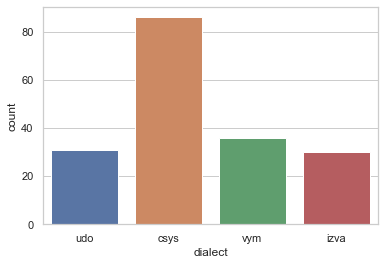

In [12]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="dialect", data=elan_df)

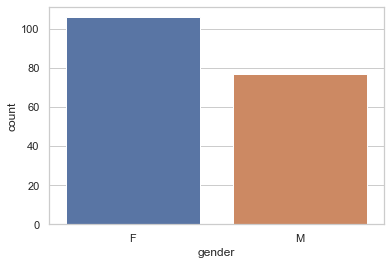

In [13]:
ax = sns.countplot(x="gender", data=elan_df)

In [14]:
elan_df.value_counts("birthyear")

birthyear
19XX    64
193X    41
1941    34
1920    31
1933    10
1913     3
dtype: int64